In [182]:
import numpy as np
embeddings_file = "/home/rohan/Documents/projects/interspecies_money/embeddings_analysis/kwitonda_portraits/embeddings/embeddings.npy"
img_fns_file = "/home/rohan/Documents/projects/interspecies_money/embeddings_analysis/kwitonda_portraits/embeddings/file_names.npy"

embeddings = np.load(embeddings_file)
print(embeddings.shape)
ids = np.load(img_fns_file)
print(ids)

(1731, 256)
['69_IMG_2024' '50_IMG_1322' '63_IMG_1616' ... '45_IMG_1152' '24_IMG_0689'
 '70_IMG_2076']


In [183]:
embeddings_file_db = "/home/rohan/Documents/projects/interspecies_money/gorillavision/reid-system/database_kwitonda/embeddings.npy"
img_fns_file_db = "/home/rohan/Documents/projects/interspecies_money/gorillavision/reid-system/database_kwitonda/labels.npy"

embeddings_db = np.load(embeddings_file_db)
ids_db = np.load(img_fns_file_db)
ids_db = np.array([id.split("_")[0] for id in ids_db])

In [186]:
from sklearn import neighbors
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score, classification_report, top_k_accuracy_score

def compute_prediction_metrics(y_true, y_pred, y_score, all_labels)-> dict:
    print(len(y_score[0]))
    print(len(y_score))
    if len(y_score[0]) == 2:
        y_score = [all_labels[score.index(min(score))] for score in y_score]

    metrics = {   
        "recall": recall_score(y_true, y_pred, average='micro'),
        "precision": precision_score(y_true, y_pred, average='micro'),
        "f1Score": f1_score(y_true, y_pred, average='micro'),
        "accuracy": accuracy_score(y_true, y_pred),
        "top_5_accuracy": top_k_accuracy_score(y_true, y_score, labels=all_labels, k=5),
        "consusion_matrix": confusion_matrix(y_true, y_pred),
        "recall_per_class": recall_score(y_true, y_pred, average=None),
        "precision_per_class": precision_score(y_true, y_pred, average=None),
        "f1Score_per_class": f1_score(y_true, y_pred, average=None),
        "individual_results": classification_report(y_true, y_pred, output_dict=True)
    }

    return metrics



knn_classifier = neighbors.KNeighborsClassifier()
knn_classifier.fit(embeddings_db, ids_db)
print(embeddings_db.shape)
print(embeddings.shape)

predicted_labels = []
predicted_scores = []
true_labels = []

sequence_ids = [int(imgfn_to_sequence[img_fn]) for img_fn in ids]
individual_ids = [seq_to_id[seq_id] for seq_id in sequence_ids]
for embedding, iid in zip(embeddings, individual_ids):
    if iid not in ids_db:
        continue
    embedding = np.expand_dims(embedding, 0)
    prediction = knn_classifier.predict(embedding)
    neighbour_scores = knn_classifier.predict_proba(embedding)[0]
    # print(len(neighbour_scores))
    # print(neighbour_scores.shape)
    predicted_labels.append(prediction)
    predicted_scores.append(neighbour_scores)
    true_labels.append(iid)
    


(53, 256)
(1731, 256)


In [184]:
# Cluster (without doing PCA before)
%pip install scikit-learn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# pca = PCA(n_components=32)
# embeddings = pca.fit_transform(embeddings)

kmeans = KMeans(n_clusters=21)
kmeans.fit(embeddings)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


/home/rohan/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=21)

In [185]:
from collections import defaultdict
import json
import os
import pandas as pd

# Load sequences
sequences_file = "/home/rohan/Documents/projects/interspecies_money/embeddings_analysis/kwitonda_portraits/data/sequences.json"
imgfn_to_sequence = {} # {img_filename: sequence_id}

with open(sequences_file, "r") as f:
    sequences = json.load(f)
    

data = pd.read_csv('labels.csv')

data.loc[data["Prediction Interspecies"] == "KWIG", "Prediction Interspecies"] = "WIG"
    
for sequence_id, sequence in sequences.items():
    for img_fn in sequence:
        img_name, ext = os.path.splitext(img_fn)
        imgfn_to_sequence[img_name] = sequence_id
        
seq_to_id = {}
for i, row in data.iterrows():
    seq_to_id[row["SL"]] = row["Prediction Interspecies"].upper()
    
sequence_ids = np.array([int(imgfn_to_sequence[img_fn]) for img_fn in ids])
individual_ids = np.array([seq_to_id[seq_id] for seq_id in sequence_ids])
np.save("individual_ids.npy", individual_ids)
np.save("sequence_ids.npy", sequence_ids)


        
num_imgs_per_cluster = {} # {cluster_id: num_imgs}

seq_cluster_ids = defaultdict(list) # {sequence_id: [cluster_ids]}
iid_cluster_ids = defaultdict(list) # {img_idx: cluster_id}
for img_idx, cluster_id in enumerate(kmeans.labels_):
    img_fn = ids[img_idx]
    sequence_id = imgfn_to_sequence[img_fn]
    seq_cluster_ids[sequence_id].append(cluster_id)
    if cluster_id not in num_imgs_per_cluster:
        num_imgs_per_cluster[cluster_id] = 1
    else:
        num_imgs_per_cluster[cluster_id] += 1
    iid = seq_to_id[int(sequence_id)]
    iid_cluster_ids[iid].append(cluster_id)


sequences_per_cluster = defaultdict(list) # {cluster_id: [sequence_ids]}
individuals_per_cluster = defaultdict(list) # {cluster_id: [individual_ids]}
for sequence_id, cluster_ids in seq_cluster_ids.items():
    iid = seq_to_id[int(sequence_id)]
    for cluster_id in set(cluster_ids):
        sequences_per_cluster[cluster_id].append(sequence_id)
        individuals_per_cluster[cluster_id].append(iid)
        
        
num_sequences_per_cluster = [len(set(sequence_ids)) for sequence_ids in sequences_per_cluster.values()]
num_individuals_per_cluster = [len(set(individual_ids)) for individual_ids in individuals_per_cluster.values()]

In [187]:
print(set(individual_ids))
print(set(ids_db))
print([pl[0] for pl in predicted_labels])
print(set([pl[0] for pl in predicted_labels]))

print((set(individual_ids).union(set(ids_db))).difference(set([pl[0] for pl in predicted_labels])))

print(len(predicted_scores[0]))
print(predicted_scores[0])
    
# all_iids = individual_ids
# all_iids.extend(ids_db.tolist())
# all_iids.extend([pl[0] for pl in predicted_labels])
unique_ids = list(set(ids_db.tolist()))
unique_ids.sort()

num_images_correct = sum([1 for idx in range(0, len(true_labels)) if true_labels[idx] == predicted_labels[idx]])
print(f"correctly classified {num_images_correct}/{len(true_labels)} images")
metrics = compute_prediction_metrics(true_labels, predicted_labels, predicted_scores, unique_ids)
print(metrics)

{'MBI', 'GAH', 'INO', 'RWU', 'NAN', 'SUL', 'WIG', 'NOT VISIBLE', 'KAT', 'NRJ', 'IKR', 'CYU', 'KAV', 'REM', 'KHA', 'NTI', 'IZO', 'ICM', 'KBU', 'ELEPHANT'}
{'IKP', 'IRZ', 'MBI', 'PAK', 'AF', 'OKA', 'UBG', 'GAH', 'RAK', 'URO', 'IFA', 'INO', 'NCH', 'RWU', 'LIS', 'SUL', 'WIG', 'NDT', 'KAT', 'CYU', 'IKR', 'NRJ', 'KIG', 'WAK', 'KIB', 'URW', 'KAV', 'INY', 'REM', 'KHA', 'NTI', 'NYI', 'ABO', 'HEM', 'MGE', 'ICM', 'KBU', 'IBE', 'NDM'}
['ABO', 'KAT', 'ABO', 'AF', 'IKR', 'IBE', 'KAV', 'GAH', 'INY', 'KAV', 'AF', 'IBE', 'AF', 'LIS', 'IBE', 'IKR', 'IKR', 'KAV', 'CYU', 'ABO', 'ICM', 'ABO', 'INO', 'ICM', 'AF', 'INY', 'KAV', 'INO', 'KBU', 'IKR', 'ABO', 'INY', 'ICM', 'ICM', 'IBE', 'ABO', 'INO', 'KBU', 'IKR', 'ABO', 'ABO', 'SUL', 'ABO', 'ABO', 'ABO', 'KAT', 'SUL', 'CYU', 'ICM', 'IKR', 'INO', 'ABO', 'KIG', 'CYU', 'ABO', 'IKR', 'ICM', 'AF', 'IBE', 'AF', 'ABO', 'NDT', 'SUL', 'CYU', 'IBE', 'KAV', 'AF', 'ICM', 'CYU', 'KAV', 'IKR', 'ICM', 'SUL', 'ABO', 'ICM', 'ABO', 'REM', 'INO', 'ICM', 'INO', 'IKR', 'AF', 'AF', 

/home/rohan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rohan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rohan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rohan/.local/lib/python3.10/site-packages/sklearn/metrics/_classific

['KAV', 'NRJ', 'CYU', 'NTI', 'KAV', 'KHA', 'KAV', 'SUL', 'KAV', 'KAV', 'RWU', 'ICM', 'REM', 'SUL', 'RWU', 'MBI', 'SUL', 'KAV', 'KAV', 'CYU', 'INO', 'KAV', 'KAV', 'NTI', 'WIG', 'RWU', 'KAV', 'NTI', 'KAV', 'SUL', 'KAV', 'KAT', 'NRJ', 'SUL', 'RWU', 'IZO', 'KAV', 'KAV', 'KAV', 'IZO', 'KAV', 'KHA', 'RWU', 'MBI', 'MBI', 'INO', 'INO', 'KAV', 'GAH', 'KAV', 'NRJ', 'KAV', 'KAV', 'KAV', 'MBI', 'KAV', 'INO', 'SUL', 'WIG', 'RWU', 'ICM', 'NTI', 'INO', 'RWU', 'KBU', 'KAV', 'RWU', 'KAV', 'ICM', 'NTI', 'REM', 'KAV', 'ICM', 'SUL', 'GAH', 'NTI', 'NTI', 'MBI', 'GAH', 'GAH', 'NRJ', 'IZO', 'KAV', 'SUL', 'NTI', 'REM', 'KAV', 'IZO', 'NTI', 'KHA', 'KAV', 'KBU', 'MBI', 'INO', 'MBI', 'INO', 'MBI', 'MBI', 'INO', 'CYU', 'NTI', 'KAV', 'MBI', 'KHA', 'KAV', 'INO', 'ICM', 'KAV', 'NTI', 'INO', 'INO', 'KAV', 'MBI', 'WIG', 'SUL', 'KAV', 'KAV', 'KAV', 'REM', 'INO', 'SUL', 'KAV', 'KHA', 'IZO', 'CYU', 'KAV', 'MBI', 'KBU', 'REM', 'KAV', 'SUL', 'NTI', 'NTI', 'IZO', 'NRJ', 'MBI', 'MBI', 'NTI', 'KBU', 'MBI', 'KBU', 'RWU', 'WIG'

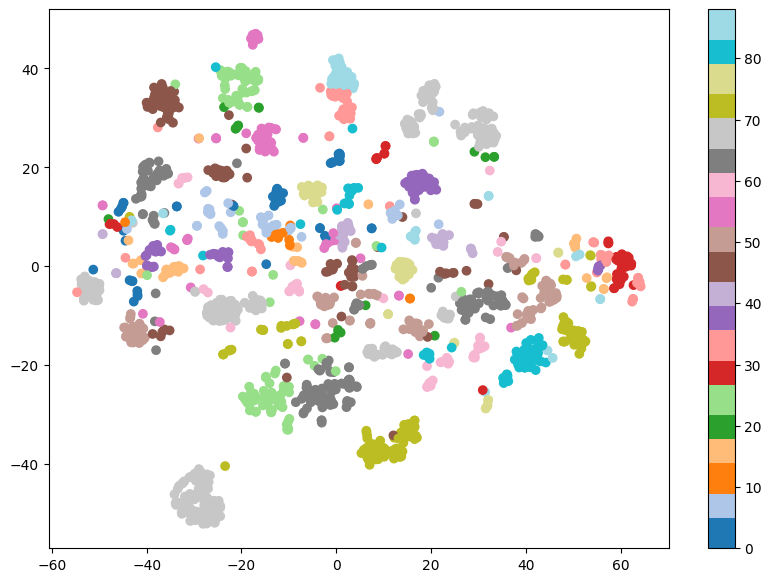

In [188]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# TODO filter db entries of individuals that are not in the dataset?

# Fit the TSNE model to the embeddings
tsne = TSNE(n_components=2)
all_embeddings = np.vstack((embeddings, embeddings_db))
embeddings_2d = tsne.fit_transform(all_embeddings)


# Split the transformed embeddings back into original and additional sets
embeddings_2d_original = embeddings_2d[:len(embeddings)]
embeddings_2d_additional = embeddings_2d[len(embeddings):]

# Get the sequence IDs and map them to individual IDs
sequence_ids = [int(imgfn_to_sequence[img_fn]) for img_fn in ids]
individual_ids = [seq_to_id[seq_id] for seq_id in sequence_ids]
print(individual_ids)

colors = plt.cm.get_cmap("tab20", len(set(sequence_ids)))
individual_ids_num_map = {ind: i for i, ind in enumerate(set(sequence_ids))}
c = [individual_ids_num_map[ind] for ind in sequence_ids]
plt.figure(figsize=(10, 7))  # Adjust the figure size if needed
plt.scatter(embeddings_2d_original[:, 0], embeddings_2d_original[:, 1], c=c, cmap=colors)
plt.colorbar()
# save the plot in high resolution
plt.savefig("/home/rohan/Documents/projects/interspecies_money/embeddings_analysis/kwitonda_portraits/embeddings/clustered_embeddings.png", dpi=300)



['KAV', 'NRJ', 'CYU', 'NTI', 'KAV', 'KHA', 'KAV', 'SUL', 'KAV', 'KAV', 'RWU', 'ICM', 'REM', 'SUL', 'RWU', 'MBI', 'SUL', 'KAV', 'KAV', 'CYU', 'INO', 'KAV', 'KAV', 'NTI', 'WIG', 'RWU', 'KAV', 'NTI', 'KAV', 'SUL', 'KAV', 'KAT', 'NRJ', 'SUL', 'RWU', 'IZO', 'KAV', 'KAV', 'KAV', 'IZO', 'KAV', 'KHA', 'RWU', 'MBI', 'MBI', 'INO', 'INO', 'KAV', 'GAH', 'KAV', 'NRJ', 'KAV', 'KAV', 'KAV', 'MBI', 'KAV', 'INO', 'SUL', 'WIG', 'RWU', 'ICM', 'NTI', 'INO', 'RWU', 'KBU', 'KAV', 'RWU', 'KAV', 'ICM', 'NTI', 'REM', 'KAV', 'ICM', 'SUL', 'GAH', 'NTI', 'NTI', 'MBI', 'GAH', 'GAH', 'NRJ', 'IZO', 'KAV', 'SUL', 'NTI', 'REM', 'KAV', 'IZO', 'NTI', 'KHA', 'KAV', 'KBU', 'MBI', 'INO', 'MBI', 'INO', 'MBI', 'MBI', 'INO', 'CYU', 'NTI', 'KAV', 'MBI', 'KHA', 'KAV', 'INO', 'ICM', 'KAV', 'NTI', 'INO', 'INO', 'KAV', 'MBI', 'WIG', 'SUL', 'KAV', 'KAV', 'KAV', 'REM', 'INO', 'SUL', 'KAV', 'KHA', 'IZO', 'CYU', 'KAV', 'MBI', 'KBU', 'REM', 'KAV', 'SUL', 'NTI', 'NTI', 'IZO', 'NRJ', 'MBI', 'MBI', 'NTI', 'KBU', 'MBI', 'KBU', 'RWU', 'WIG'

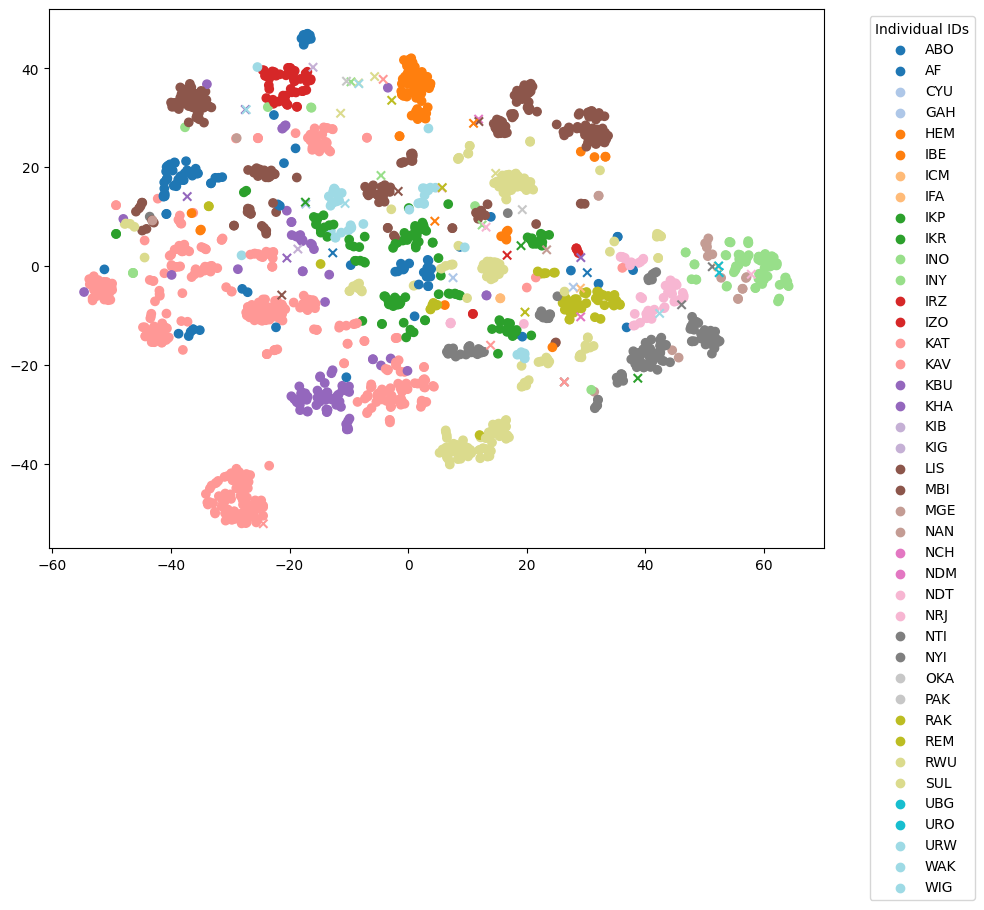

In [189]:
exclude = ["ELEPHANT", "NOT VISIBLE"]
print(individual_ids)
mask = np.array([iid not in exclude for iid in individual_ids])
embeddings_2d_original = embeddings_2d_original[mask]
individual_ids_original = individual_ids
individual_ids = [iid for i, iid in enumerate(individual_ids) if mask[i]]

additional_individual_ids = ids_db.tolist()

# Unique individual IDs
unique_individual_ids = sorted(set(individual_ids + additional_individual_ids))

# Color map for distinct colors
colors = plt.cm.get_cmap("tab20", len(unique_individual_ids))
individual_ids_num_map = {ind: i for i, ind in enumerate(unique_individual_ids)}
c_original = [individual_ids_num_map[ind] for ind in individual_ids]
c_additional = [individual_ids_num_map[ind] for ind in additional_individual_ids]

# Create the scatter plot
plt.figure(figsize=(10, 7))  # Adjust the figure size if needed

# Plot original embeddings
scatter_original = plt.scatter(embeddings_2d_original[:, 0], embeddings_2d_original[:, 1], 
                               c=c_original, cmap=colors, marker='o')

# Plot additional embeddings with a different marker
scatter_additional = plt.scatter(embeddings_2d_additional[:, 0], embeddings_2d_additional[:, 1], 
                                 c=c_additional, cmap=colors, marker='x')

# Create a legend with the individual IDs
legend_labels = {ind: colors(individual_ids_num_map[ind]) for ind in unique_individual_ids}
for label, color in legend_labels.items():
    plt.scatter([], [], color=color, label=label)

# Position the legend outside the plot
plt.legend(title="Individual IDs", bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot in high resolution
plt.savefig("/home/rohan/Documents/projects/interspecies_money/embeddings_analysis/kwitonda_portraits/embeddings/clustered_embeddings.png", dpi=300, bbox_inches='tight')


In [190]:
# Evaluate cluster quality

num_clusters_per_seq = [len(set(cluster_ids)) for cluster_ids in seq_cluster_ids.values()] 
num_clusters_per_individual = [len(set(cluster_ids)) for cluster_ids in iid_cluster_ids.values()]
print("Average number of clusters per sequence: ", np.mean(num_clusters_per_seq))
print("Average number of sequences per cluster: ", np.mean(num_sequences_per_cluster))
print("Average number of clusters per individual: ", np.mean(num_clusters_per_individual))
print("Average number of individuals per cluster: ", np.mean(num_individuals_per_cluster))

print("Number of sequences per cluster")
# for each cluster print num of sequences/total sequences in each cluster
for cluster_id, sequence_ids in sequences_per_cluster.items():
    num_imgs_in_cluster = num_imgs_per_cluster[cluster_id]
    print(f"Cluster {cluster_id}: Containes images from {len(set(sequence_ids))}/{len(sequences)} sequences. Total images in cluster: {num_imgs_in_cluster}")


print("Number of individuals per cluster")
# for each cluster print num of sindivudlas/total individuals in each cluster
for cluster_id, individual_ids in individuals_per_cluster.items():
    num_imgs_in_cluster = num_imgs_per_cluster[cluster_id]
    print(f"Cluster {cluster_id}: Containes images from {len(set(individual_ids))}/{len(set(iid_cluster_ids.keys()))} individuals. Total images in cluster: {num_imgs_in_cluster}")


Average number of clusters per sequence:  2.853932584269663
Average number of sequences per cluster:  12.095238095238095
Average number of clusters per individual:  7.65
Average number of individuals per cluster:  7.285714285714286
Number of sequences per cluster
Cluster 13: Containes images from 2/89 sequences. Total images in cluster: 65
Cluster 1: Containes images from 29/89 sequences. Total images in cluster: 178
Cluster 2: Containes images from 16/89 sequences. Total images in cluster: 104
Cluster 3: Containes images from 26/89 sequences. Total images in cluster: 104
Cluster 6: Containes images from 9/89 sequences. Total images in cluster: 89
Cluster 14: Containes images from 13/89 sequences. Total images in cluster: 97
Cluster 16: Containes images from 19/89 sequences. Total images in cluster: 99
Cluster 5: Containes images from 27/89 sequences. Total images in cluster: 84
Cluster 7: Containes images from 15/89 sequences. Total images in cluster: 143
Cluster 9: Containes images f

In [191]:
print("Number of frames per cluster for each sequence")
# for each sequence print num of frames/total frames in each cluster
for sequence_id, cluster_ids in seq_cluster_ids.items():
    cluster_counts = {cluster_id: cluster_ids.count(cluster_id) for cluster_id in set(cluster_ids)}
    # sort by count in descending order
    cluster_counts = dict(sorted(cluster_counts.items(), key=lambda item: item[1], reverse=True))
    print(f"Sequence {sequence_id}: {cluster_counts}")

Number of frames per cluster for each sequence
Sequence 69: {13: 64}
Sequence 50: {2: 17, 14: 14, 16: 6, 6: 5, 1: 4, 3: 4}
Sequence 63: {18: 27, 7: 4, 3: 2, 5: 2, 9: 2, 10: 1, 12: 1}
Sequence 72: {2: 35, 5: 1, 14: 1}
Sequence 65: {7: 56, 3: 6, 5: 4, 18: 4, 2: 3, 10: 2, 16: 2, 17: 2, 9: 1}
Sequence 25: {7: 9, 18: 2, 3: 2, 5: 1}
Sequence 57: {18: 3, 10: 3, 5: 3}
Sequence 62: {2: 6, 1: 2, 7: 2, 16: 1, 19: 1}
Sequence 71: {1: 20, 10: 1, 11: 1, 7: 1}
Sequence 68: {11: 85, 0: 35, 5: 2}
Sequence 58: {2: 21, 1: 11, 3: 11, 16: 2, 17: 1}
Sequence 87: {8: 35}
Sequence 64: {16: 37, 14: 9, 1: 6, 2: 1, 17: 1}
Sequence 39: {19: 39}
Sequence 73: {17: 60, 3: 1}
Sequence 46: {9: 46}
Sequence 75: {15: 27}
Sequence 52: {1: 5, 16: 1}
Sequence 49: {18: 32, 17: 1, 7: 1}
Sequence 66: {1: 17, 16: 7, 7: 1}
Sequence 82: {16: 8, 3: 7, 1: 3, 17: 2, 14: 1}
Sequence 24: {12: 53, 9: 1}
Sequence 30: {6: 35, 5: 1}
Sequence 37: {10: 16, 5: 6}
Sequence 38: {6: 5}
Sequence 26: {7: 47, 17: 1, 10: 1}
Sequence 45: {7: 15, 9:

In [192]:
print("Number of frames from sequence per cluster")
# for each cluster print num of frames/total frames from each sequence in each cluster
for cluster_id, sequence in sequences_per_cluster.items():
    sequence_counts = {sequence_id: seq_cluster_ids[sequence_id].count(cluster_id) for sequence_id in set(sequence)}
    # sort by count in descending order
    sequence_counts = dict(sorted(sequence_counts.items(), key=lambda item: item[1], reverse=True))
    print(f"Cluster {cluster_id}: {sequence_counts}") 

Number of frames from sequence per cluster
Cluster 13: {'69': 64, '60': 1}
Cluster 1: {'51': 20, '71': 20, '40': 18, '66': 17, '2': 17, '3': 12, '58': 11, '54': 8, '15': 8, '64': 6, '52': 5, '28': 4, '50': 4, '88': 3, '79': 3, '82': 3, '27': 3, '47': 3, '77': 2, '62': 2, '67': 1, '18': 1, '22': 1, '85': 1, '42': 1, '33': 1, '23': 1, '5': 1, '1': 1}
Cluster 2: {'72': 35, '58': 21, '50': 17, '62': 6, '80': 4, '47': 4, '44': 4, '65': 3, '79': 2, '74': 2, '84': 1, '51': 1, '83': 1, '17': 1, '64': 1, '45': 1}
Cluster 3: {'79': 11, '58': 11, '5': 10, '33': 9, '6': 9, '82': 7, '65': 6, '8': 5, '50': 4, '7': 3, '12': 3, '10': 3, '23': 3, '47': 3, '63': 2, '61': 2, '13': 2, '25': 2, '54': 2, '55': 1, '4': 1, '73': 1, '3': 1, '0': 1, '44': 1, '17': 1}
Cluster 6: {'30': 35, '32': 24, '17': 8, '50': 5, '74': 5, '38': 5, '84': 4, '76': 2, '86': 1}
Cluster 14: {'80': 45, '42': 14, '50': 14, '64': 9, '78': 5, '47': 3, '86': 1, '85': 1, '41': 1, '82': 1, '17': 1, '72': 1, '88': 1}
Cluster 16: {'64': 3

In [193]:
# Possible next steps: For each cluster, check which sequences represent the same individual to identify how many 
# wrongly placed individuals are in the cluster


In [194]:
# if a sequence is distributed over multiple sequences, compute the how furthest neighbour the cluster is from the other cluster of the same sequence
# fill in the code for the dsrcibed functionality now:

# get centroids of all clusters
cluster_centroids = kmeans.cluster_centers_

cluster_distances = []
for cluster_id, _ in enumerate(cluster_centroids):
    distances = []
    for other_cluster_id, _2 in enumerate(cluster_centroids):
        distance = float(np.linalg.norm(cluster_centroids[cluster_id] - cluster_centroids[other_cluster_id]))
        distances.append(distance)
    cluster_distances.append(sorted(distances))
    
# sort all distances
    
distances = []
distance_counts = []
# for each sequence, find the cluster with the most frames
for sequence_id, cluster_ids in seq_cluster_ids.items():
    cluster_counts = {cluster_id: cluster_ids.count(cluster_id) for cluster_id in set(cluster_ids)}
    max_cluster = max(cluster_counts, key=cluster_counts.get)
    max_cluster_centroid = cluster_centroids[max_cluster]
    for cluster_id in cluster_counts:
        if cluster_id != max_cluster:
            distance = float(np.linalg.norm(max_cluster_centroid - cluster_centroids[cluster_id]))
            k = cluster_distances[max_cluster].index(distance)
            distances.append(k)
            distance_counts.extend([k]*cluster_counts[cluster_id])
            
# print count number smaller 5
print("Number of clusters that are the closest to the cluster of the same sequence: ", len([d for d in distances if d <= 4]))
print("Number of clusters that are not close to the cluster of the same sequence: ", len([d for d in distances if d > 4]))

print(np.mean([d for d in distances if d >5]))
print("Average distance between clusters of the same sequence: ", np.mean(distances))

print("Average distance between clusters of the same sequence (image count): ", np.mean(distance_counts))

Number of clusters that are the closest to the cluster of the same sequence:  67
Number of clusters that are not close to the cluster of the same sequence:  98
10.397590361445783
Average distance between clusters of the same sequence:  6.66060606060606
Average distance between clusters of the same sequence (image count):  5.672131147540983


In [195]:
# if a individual is distributed over multiple clusters, compute the how furthest neighbour the cluster is from the other cluster of the same individual
# fill in the code for the dsrcibed functionality now:

# get centroids of all clusters
cluster_centroids = kmeans.cluster_centers_

cluster_distances = []
for cluster_id, _ in enumerate(cluster_centroids):
    distances = []
    for other_cluster_id, _2 in enumerate(cluster_centroids):
        distance = float(np.linalg.norm(cluster_centroids[cluster_id] - cluster_centroids[other_cluster_id]))
        distances.append(distance)
    cluster_distances.append(sorted(distances))
    
# sort all distances

distances = []
distance_counts = []
# for each individual, find the cluster with the most frames
for iid, cluster_ids in iid_cluster_ids.items():
    cluster_counts = {cluster_id: cluster_ids.count(cluster_id) for cluster_id in set(cluster_ids)}
    max_cluster = max(cluster_counts, key=cluster_counts.get)
    max_cluster_centroid = cluster_centroids[max_cluster]
    for cluster_id in cluster_counts:
        if cluster_id != max_cluster:
            distance = float(np.linalg.norm(max_cluster_centroid - cluster_centroids[cluster_id]))
            k = cluster_distances[max_cluster].index(distance)
            distances.append(k)
            distance_counts.extend([k]*cluster_counts[cluster_id])
            
# print count number smaller 5
print("Number of clusters that are the closest to the cluster of the same individual: ", len([d for d in distances if d <= 4]))
print("Number of clusters that are not close to the cluster of the same individual: ", len([d for d in distances if d > 4]))

print(np.mean([d for d in distances if d >5]))
print("Average distance between clusters of the same individual: ", np.mean(distances))

print("Average distance between clusters of the same individual (image count): ", np.mean(distance_counts))


Number of clusters that are the closest to the cluster of the same individual:  46
Number of clusters that are not close to the cluster of the same individual:  87
12.115384615384615
Average distance between clusters of the same individual:  8.240601503759398
Average distance between clusters of the same individual (image count):  6.382956878850103


In [196]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score, classification_report, top_k_accuracy_score


def compute_prediction_metrics(y_true, y_pred, y_score, all_labels)-> dict:
    if len(y_score[0]) == 2:
        y_score = [all_labels[score.index(min(score))] for score in y_score]

    metrics = {   
        "recall": recall_score(y_true, y_pred, average='micro'),
        "precision": precision_score(y_true, y_pred, average='micro'),
        "f1Score": f1_score(y_true, y_pred, average='micro'),
        "accuracy": accuracy_score(y_true, y_pred),
        "top_5_accuracy": top_k_accuracy_score(y_true, y_score, labels=all_labels, k=5),
        "consusion_matrix": confusion_matrix(y_true, y_pred),
        "recall_per_class": recall_score(y_true, y_pred, average=None),
        "precision_per_class": precision_score(y_true, y_pred, average=None),
        "f1Score_per_class": f1_score(y_true, y_pred, average=None),
        "individual_results": classification_report(y_true, y_pred, output_dict=True)
    }

    return metrics

In [197]:
# use knn to compute top k accurracy of embeddings with db
from sklearn import neighbors
knn_classifier = neighbors.KNeighborsClassifier()
knn_classifier.fit(embeddings_db, ids_db)
print(embeddings_db.shape)
print(embeddings.shape)

predicted_labels = []
predicted_scores = []
true_labels = []

individual_ids = [seq_to_id[seq_id] for seq_id in sequence_ids]
for embedding, iid in zip(embeddings, individual_ids):
    embedding = np.expand_dims(embedding, 0)
    prediction = knn_classifier.predict(embedding)
    neighbour_scores = knn_classifier.predict_proba(embedding)[0]
    predicted_labels.append(prediction)
    predicted_scores.append(neighbour_scores)
    true_labels.append(iid)

(53, 256)
(1731, 256)


KeyError: '18'

In [ ]:
all_iids = individual_ids_original + ids_db.tolist()
unique_ids = list(set(all_iids))
unique_ids.sort()

num_images_correct = sum([1 for idx in range(0, len(true_labels)) if true_labels[idx] == predicted_labels[idx]])
print(f"correctly classified {num_images_correct}/{len(true_labels)} images")
metrics = compute_prediction_metrics(true_labels, predicted_labels, predicted_scores, unique_ids)
print(metrics)

correctly classified 0/2 images


ValueError: Number of given labels (43) not equal to the number of classes in 'y_score' (39).